## Problema de negócio

O cfo da empresa fez uma reunião com todos os gerentes de loja e pediu para que cada um dele trouxesse uma previsão diária das próximas 6 semanas de vendas.
Cada gerente entrou em contato com você para requisitar a previsão de vendas.

A motivação.
- Qual o contexto?
Reunião de resultados mensais.

A causa raiz do problema.
- Porque fazer uma previsão de vendas?
Previsão de quanto de dinheiro entrará para fazer a reforma da loja.

Quem é o dono do problema?
- Quem será o stakeholder?
CFO ou diretor que tem a regra de negócio.

Formato da solução
- Qual é a granularidade?
= Previsão de vendas dia por loja nas próximas 6 semanas.
- Tipo do problema.
= Previsão de vendas
- Potenciais Métodos.
= Time series, regressão, redes neurais
- Formato da entrega.
= Receber pelo celular a previsão.

Ciclo CRISP. Cross-Industry Process - DS
- 1 versão end to end da solução
- Velocidade na entrega de valor.
- Mapemaneto de todos os possíveis problemas.

Etapas:
1 - Questão de negócio -> Entendimento do negócio -> Coleta de dados -> Limpeza dos dados -> Exploração dos dados -> Modelagem dos dados -> Algoritmos de machine learning -> Avaliação do algorítimo -> Modelo em prod

## 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import inflection 
import math 
from IPython.display import Image

## 0.1 Helper Functions

## 0.2 Loading data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
84808,69,6,2015-05-16,6918,993,1,0,0,0,c,c,1130.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


## 1.0 Data descriptions

In [4]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore ( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [9]:
#transforming date time
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA
competition_distance -> Assumir que lojas que estão muito distantes não são consideradas competidoras por isso é NA.

competition_open_since_month -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

competition_open_since_year -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo2_since_week ->  Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo2_since_year -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo_interval -> Split da coluna e criar uma lista, caso minha data esteja na lista, a promoção 2 foi ativa.

In [11]:
#competition_distance - distance in meters to the nearest competitor store
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#promo2_since_year        
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#promo_interval     
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
                                                            in x['promo_interval'].split(',')
                                                            else 0, axis=1)

## 1.6 Change Types

In [ ]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [ ]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.149166,0.0,0.356252,1.969586,1.879273


## 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

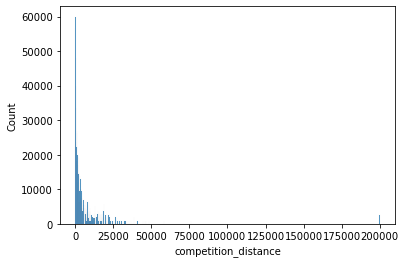

In [ ]:
sns.histplot( df1['competition_distance'], kde=False )

<AxesSubplot:xlabel='assortment', ylabel='sales'>

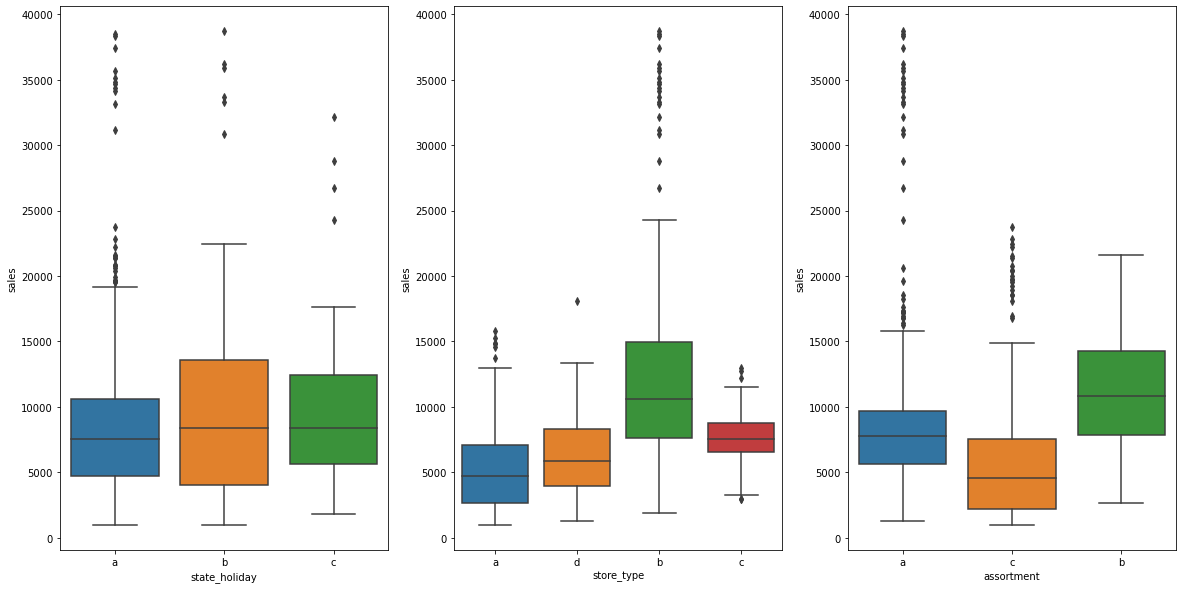

In [ ]:
plt.figure(figsize=(20, 10))

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )


## HIPOTESIS MINDMAP

- Fenômeno: Qual modelo estou modelando?
- Agentes: Quem são os agentes que atuam sobre o fenômeno de interesse?
- Atributos dos Agentes: Qual a descrição dos agentes?
- Lista de Hipóteses: Hipóteses para validar com dados

In [ ]:
Image('D:\data-science\datascience-projects\ds-producao\img\MIND_MAP.PNG')

NameError: name 'Image' is not defined

## 2.1 Hypotheses creation

### 2.1.1 Store Hipotheses

1 - Stores with a higher number of employees should sell more.

2 - Stores with larger inventory capacity should sell more.

3 - Stores with larger size should sell more.

4 - Stores with a wider assortment should sell more.

5 - Stores with closer competitors should sell less.

6 - Stores with competitors that have been around longer should sell more.

### 2.1.2 Product Hipotheses

1 - Stores that invest more in marketing should sell more.

2 - Stores with greater product exposure should sell more.

3 - Stores with lower-priced products should sell more.

4 - Stores with more aggressive promotions (larger discounts) should sell more.

5 - Stores with promotions active for longer periods should sell more.

6 - Stores with more days of promotion should sell more.

7 - Stores with more consecutive promotions should sell more.

### 2.1.3 Time Hipotheses

1 - Stores open during the Christmas holiday should sell more.

2 - Stores should sell more over the years.

3 - Stores should sell more in the second half of the year.

4 - Stores should sell more after the 10th of each month.

5 - Stores should sell less on weekends.

6 - Stores should sell less during school holidays.

### 2.1.4 Final Hipotheses

1 - Stores with a wider assortment should sell more.

2 - Stores with closer competitors should sell less.

3 - Stores with competitors that have been around longer should sell more.

4 - Stores with promotions active for longer periods should sell more.

5 - Stores with more days of promotion should sell more.

6 - Stores with more consecutive promotions should sell more.

7 - Stores open during the Christmas holiday should sell more.

8 - Stores should sell more over the years.

9 - Stores should sell more in the second semester of the year.

10 - Stores should sell more after the 10th of each month.

11 - Stores should sell less on weekends.

12 - Stores should sell less during school holidays.

## 2.2 Feature Engineering

In [ ]:
df2 = df1.copy()

In [ ]:
#year
df2['year'] = df2['date'].dt.year
#day
df2['day'] = df2['date'].dt.day
#month
df2['month'] = df2['date'].dt.month
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
#assortiment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 Variable Filtering

In [ ]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,day,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,31,7,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtering rows

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,day,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,31,7,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.2 Selecting Columns

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
